# Checklist for Machine Learning Analyses
v0.1 11/27/2023

**Daniel M. Low**
DAIR Center, Child Mind Institute
Department of Psychology, Harvard University
daniel.low@childmind.org

---

## Stages of a machine learning analysis
This notebook serves as a checklist and guide for conducting machine learning analyses, covering reproducibility, planning, preprocessing, EDA, training, evaluation, and code quality.

In [1]:
# Install necessary packages
!pip install shap imbalanced-learn
# !pip install numpy pandas scikit-learn matplotlib seaborn 

## Reproducibility
- Set up a virtual environment: https://github.com/danielmlow/tutorials/blob/main/virtual_environment.md 
- What is a virtual environment? https://github.com/danielmlow/tutorials/blob/main/run_python.md#virtual-environments-anaconda-or-miniconda 

## Planning the type of task and validation

- **Define task**: unsupervised, supervised (classification, regression)
    - No outcome variable → unsupervised learning. Plot the distribution of your outcome variable.
    - Metric output → regression
    - Ordinal → ordinal regression or ordinal classification, perhaps bin into 3 or 4 levels if you have more. If you have a scale that is quite wide, it might be helpful to try binning into 3 or 4 groups. However, you'll lose information, especially if you bin into two groups (high vs. low since 5 and 6 on a 10-point scale might end up in different groups even though they're similar). So worth trying both ways. `sklearn`'s `KBinsDiscretizer` can help you find a more uniform distribution.
        - Common approach is to do standard regression and treat outcome as metric.
        - Ordinal regression (but that would be trying only this linear model): https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html 
        - Treating it as a classification problem: https://github.com/leeprevost/OrdinalClassifier/tree/main 
    - Categorical
        - **Binary classification**: one correct category out of two 
        - **Multiclass classification**: one correct category out of multiple
        - **Multi-label classification**: multiple possible correct categories outputs. Benefits: learns information about all classes together.

- **Imbalanced data**
    - Try oversampling, class weights, SMOTE, and/or undersampling during training. Class weights tend to not work as well for stronger (> 60-40) imbalance, but worth trying since all `sklearn` methods have it. 
    - Use https://imbalanced-learn.org. 
    - **Don't touch test sets**: they which will remain imbalanced and reflect new samples / out of sample distributions. 
    - **Evaluation**: This might result in some metrics appearing overconfident (accuracy and ROC AUC, if they weigh true negatives a lot). So prioritize looking at F1 score and Area Under the Precision-Recall curve.

- **How will you split your data?** Held-out test set, k-fold CV, bootstrapping
    - \> 1000 samples: you could probably use just a train-test split, and a validation set inside the train set for hyperparameter tuning.
    - < 500 samples: do nested k-fold. 5, 7 and 10 are normal values for k. 
    - < 100 samples: consider doing nested bootstrapping (lab 2), will be slower. `pydra-ml` can help with this [see Figure 5: Low et al (2020). Automated assessment of psychiatric disorders using speech: A systematic review. *Laryngoscope investigative otolaryngology*]. 
    - It's all about determining if the test sets represent the data well or if a different test would have produced different results. k-fold and bootstrapping is always better but too time intensive as datasets become larger and it doesn't make a difference with larger datasets (depends on the specific problem as well). 

- **Longitudinal data or other repeated measures**
    - **Concurrent prediction**: use group shuffle split to have all samples of an individual in either the train set or test set but not both (if not, the model could overfit by learning to predict the identity of each person if the feature vector is rich in information) (see lab 6).
    - **Prospective prediction** (predict next time point from prior time points): time series cross-validation.

- **Pre-register** or at least write down hypotheses as to which variables should be important for predicting the target group to avoid HARKing (Hypothesizing After the Results are Known).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, cross_validate, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from collections import Counter
from matplotlib.patches import Patch
import seaborn as sns


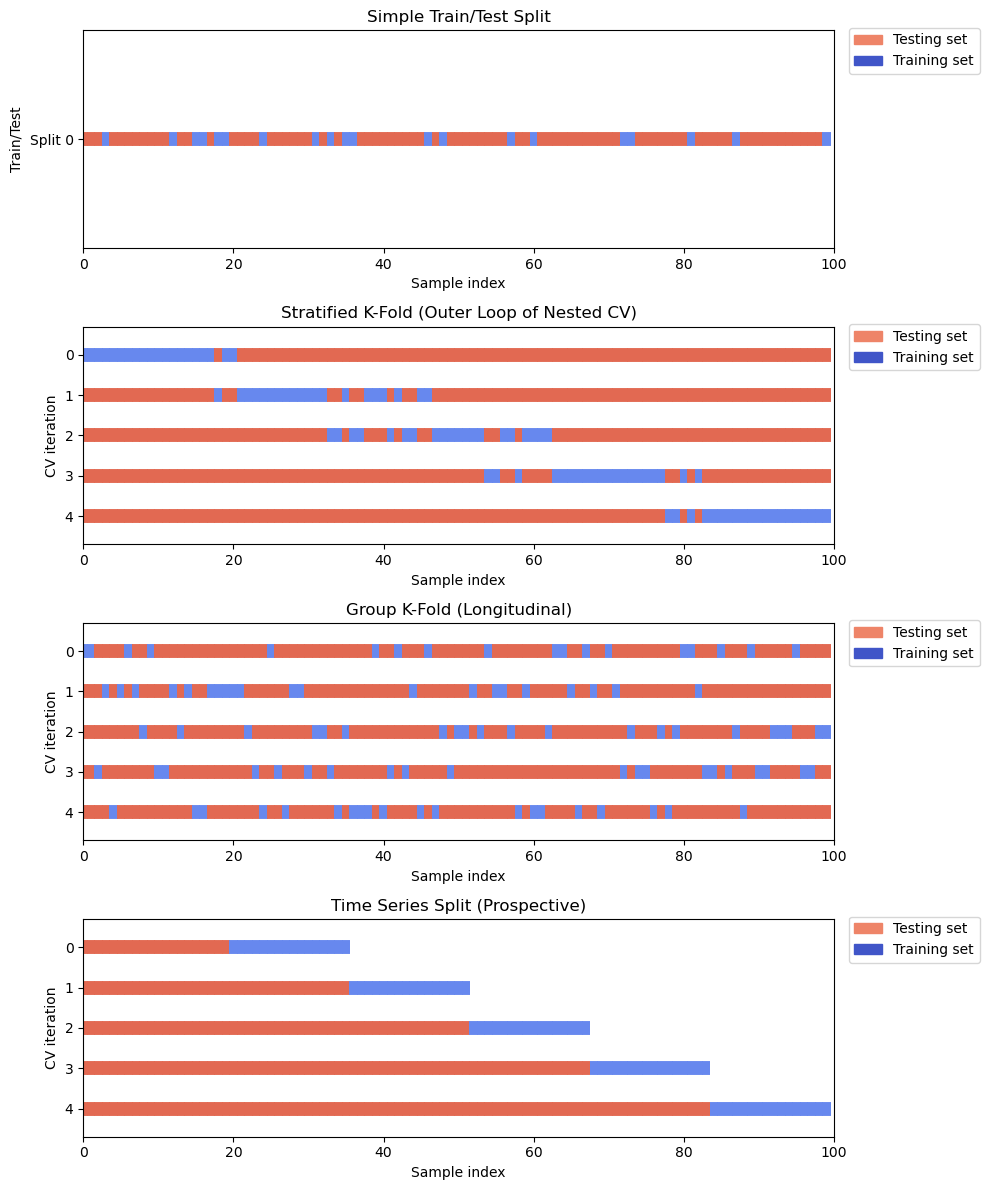

In [19]:
# --- Visualization of How Splitting is Done (Schematic) ---
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split

def plot_simple_split(X, y, group, ax, n_splits=1, test_size=0.2, lw=10):
    """Plot a simple train/test split in the same style as CV plots."""
    # Only one “split”
    tr, tt = train_test_split(np.arange(len(X)), test_size=test_size, random_state=42, stratify=y)
    indices = np.array([np.nan] * len(X))
    indices[tr] = 1
    indices[tt] = 0

    # Visualize
    ax.scatter(range(len(indices)), [0.5] * len(indices),
               c=indices, marker='_', lw=lw, cmap=cmap_cv,
               vmin=-.2, vmax=1.2)

    # Formatting
    ax.set(yticks=[0.5], yticklabels=['Split 0'],
           xlabel='Sample index', ylabel='Train/Test',
           ylim=[1, 0], xlim=[0, len(X)])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, 0.8))
    ax.set_title('Simple Train/Test Split')
    return ax


cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tr] = 1
        indices[tt] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2], xlim=[0, len(X)]) # xlim adjusted for 100 samples visualization
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    return ax

# Create schematic data (100 samples)
X_viz, y_viz = make_classification(n_samples=100, n_features=20, random_state=42)
groups_viz = np.random.randint(0, 10, size=100) # 10 groups

fig, ax = plt.subplots(4, 1, figsize=(10, 12))

# 0. Train-test split
plot_simple_split(X_viz, y_viz, None, ax[0], n_splits=1, test_size=0.2)

# ax[0].set_title('Train-test')
# plt.tight_layout()
# plt.show()

# 1. KFold (Simple/Nested Outer)
cvs = [StratifiedKFold(n_splits=5), GroupKFold(n_splits=5)]

plot_cv_indices(StratifiedKFold(n_splits=5), X_viz, y_viz, None, ax[1], 5)
ax[1].set_title('Stratified K-Fold (Outer Loop of Nested CV)')

# 2. Group KFold
plot_cv_indices(GroupKFold(n_splits=5), X_viz, y_viz, groups_viz, ax[2], 5)
ax[2].set_title('Group K-Fold (Longitudinal)')

# 3. Time Series Split (Prospective)
from sklearn.model_selection import TimeSeriesSplit
plot_cv_indices(TimeSeriesSplit(n_splits=5), X_viz, y_viz, None, ax[3], 5)
ax[3].set_title('Time Series Split (Prospective)')

plt.tight_layout()
plt.show()

In [4]:

# Simulate an imbalanced dataset
# Weights=[0.9, 0.1] means 90% class 0, 10% class 1
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                           n_redundant=2, n_classes=2, weights=[0.9, 0.1], 
                           random_state=42)

print(f"Original Class Distribution: {Counter(y)}")

# Helper function to visualize train/test splits
def visualize_strategy_split(X_train, X_test, y_train, y_test, title):
    pca = PCA(n_components=2)
    
    # Combine for PCA calculation to ensure same projection
    X_combined = np.vstack((X_train, X_test))
    X_pca = pca.fit_transform(X_combined)
    
    X_train_pca = X_pca[:len(X_train)]
    X_test_pca = X_pca[len(X_train):]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. First Two Features
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c='blue', alpha=0.5, label='Train', marker='o')
    axes[0].scatter(X_test[:, 0], X_test[:, 1], c='orange', alpha=0.5, label='Test', marker='x')
    axes[0].set_title(f"{title}: Feat 1 vs Feat 2")
    axes[0].legend()
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    
    # 2. PCA
    axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', alpha=0.5, label='Train', marker='o')
    axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c='orange', alpha=0.5, label='Test', marker='x')
    axes[1].set_title(f"{title}: PCA 1 vs PCA 2")
    axes[1].set_xlabel('PC 1')
    axes[1].set_ylabel('PC 2')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

Original Class Distribution: Counter({np.int64(0): 897, np.int64(1): 103})


1. Simple Train-Test Split
Train/Test sizes: 800, 200


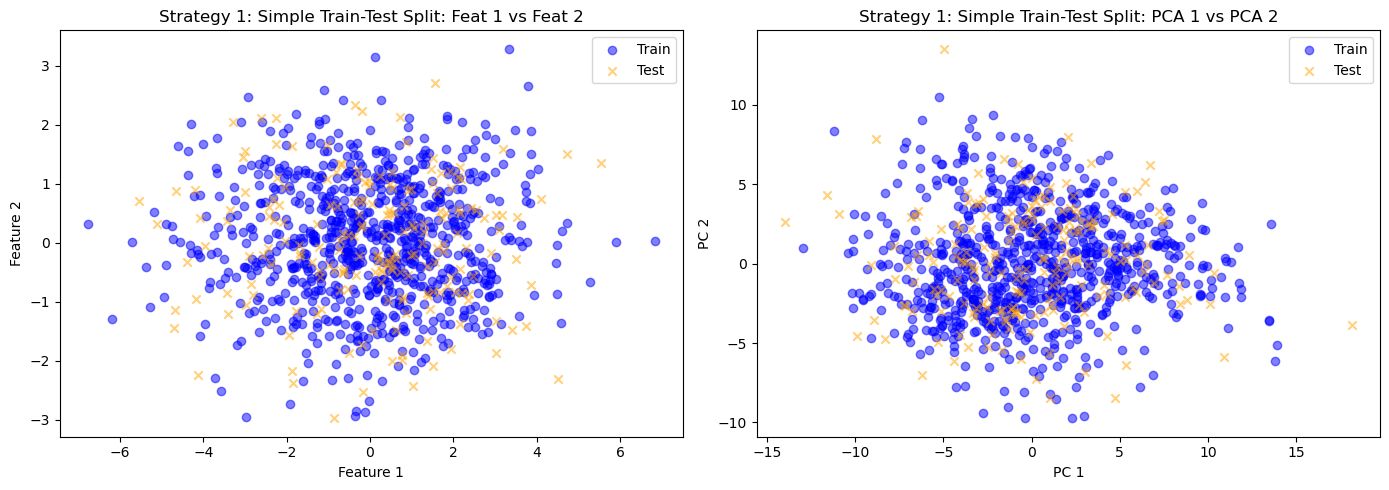

In [5]:
# --- 1. Simple Split ---
print("1. Simple Train-Test Split")
# 80/20 Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train/Test sizes: {X_train.shape[0]}, {X_test.shape[0]}")

# Visualize Simple Split
visualize_strategy_split(X_train, X_test, y_train, y_test, "Strategy 1: Simple Train-Test Split")


2. Nested K-Fold Cross-Validation
Nested CV F1 Scores: [0.36363636 0.28571429 0.52631579 0.22222222 0.54545455]
Mean F1: 0.389


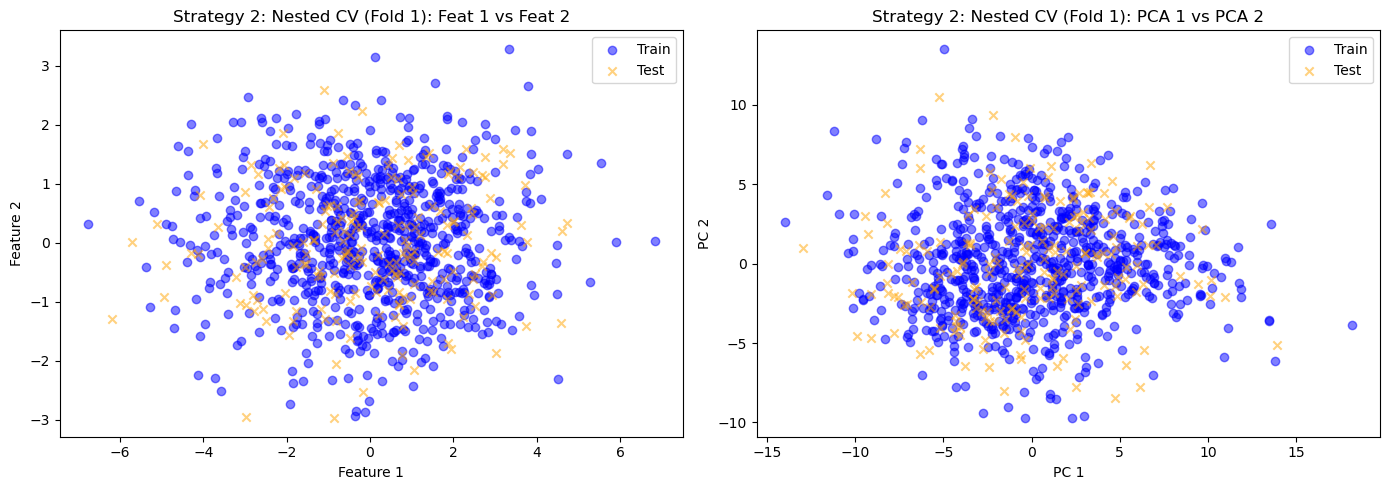

In [6]:
# --- 2. Nested K-Fold Cross-Validation ---
# Nested CV is often used for model selection and error estimation.
# Inner loop: Hyperparameter tuning. Outer loop: Error estimation.
print("\n2. Nested K-Fold Cross-Validation")

# We will simulate the outer loop here.
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner loop would be inside (e.g. GridSearchCV) - handled in Section 5/6 usually.
# Here we just show the metric evaluation using cross_validate
clf = LogisticRegression(solver='liblinear') # Simple model
nested_scores = cross_validate(clf, X, y, cv=outer_cv, scoring='f1', return_train_score=False)
print(f"Nested CV F1 Scores: {nested_scores['test_score']}")
print(f"Mean F1: {nested_scores['test_score'].mean():.3f}")

# Visualize Nested CV (Showing Fold 1)
# Note: In cross-validation, every sample is in the test set once.
train_ix, test_ix = next(outer_cv.split(X, y))
visualize_strategy_split(X[train_ix], X[test_ix], y[train_ix], y[test_ix], "Strategy 2: Nested CV (Fold 1)")


3. Nested Bootstrapping (Simulation n=500)
Bootstrap (OOB) Accuracy Scores: ['0.91', '0.91', '0.92', '0.90', '0.92']


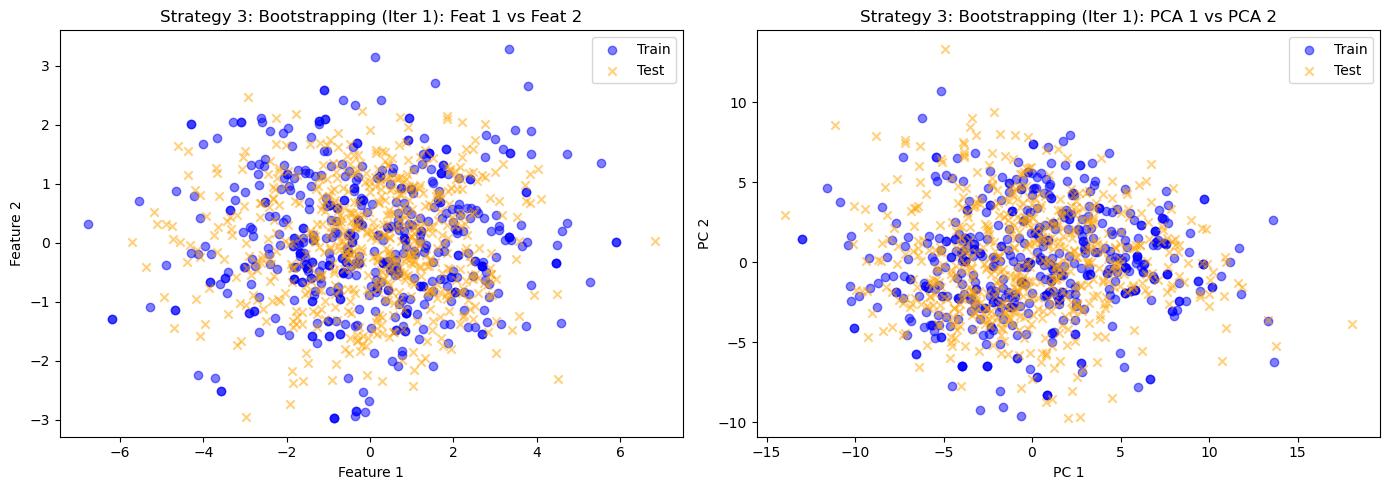

In [7]:
# --- 3. Nested Bootstrapping ---
# Useful for small datasets. Here n=1000 is large enough for CV, but we demonstrate for n=500.
print("\n3. Nested Bootstrapping (Simulation n=500)")
from sklearn.utils import resample

n_iterations = 5 
n_size = int(len(X) * 0.5) # simulating smaller dataset size effectively or just subsampling

stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train_ix = resample(range(len(X)), n_samples=500, replace=True, random_state=i)
    # in standard bootstrap, OOB (Out of Bag) samples are test. 
    # Or strict train/test split on the resampled data.
    # Here we utilize OOB for testing to adhere to standard bootstrapping validation
    test_ix = [x for x in range(len(X)) if x not in train_ix]
    
    # fit model
    model = LogisticRegression(solver='liblinear')
    model.fit(X[train_ix], y[train_ix])
    
    # evaluate model
    # predictions = model.predict(X[test_ix]) # If using OOB
    # For "Nested", you would do another bootstrap or CV inside `train_ix`.
    score = model.score(X[test_ix], y[test_ix]) # Accuracy for simplicity
    stats.append(score)

print(f"Bootstrap (OOB) Accuracy Scores: {[f'{s:.2f}' for s in stats]}")

# Visualize Bootstrapping (Iteration 1)
# Re-create indices for viz
train_ix_boot = resample(range(len(X)), n_samples=500, replace=True, random_state=0)
test_ix_boot = [x for x in range(len(X)) if x not in train_ix_boot]
visualize_strategy_split(X[train_ix_boot], X[test_ix_boot], y[train_ix_boot], y[test_ix_boot], "Strategy 3: Bootstrapping (Iter 1)")

## Preprocessing

- **Defining variables**: independent variables X and dependent variable y:
    - Remove wrong columns (ID, outcome variable) that are not features. 
    - Index features with column names `df[list_of_col_names]` instead of `df.iloc[2:43]` to avoid including incorrect columns.

- **Shuffle rows**: Some algorithms expect your rows to be shuffled. Shuffle rows with pandas `df.sample(frac=1)` which will shuffle in place. `train_test_split(X,y, shuffle=True)` may also work but check there isn't some natural order after `train_test_split` (e.g., first all the 0s, then all the 1s). 

- **Check column variable types** with `df.info(verbose=1)` and convert categorical variables to dummy variables (if there are more than two values). 
- Make sure all metric variables are float or int (whatever they should be). 

- **Dummy code categorical features**. Remove redundant columns (remove 'male' if 'female' is just the inverse, you can just keep 'female' indicator variable). Columns with little variance (if value "other" existed for gender in 3% of the cases, patterns associated to this value might not be learnable by most machine learning models, doesn't hurt to leave it in though), so perhaps remove that dummy column.

- **Feature extraction** 
    - You can create interaction terms, take statistics (mean, SD, etc) on time signals. 

- **Feature engineering**: It can be time consuming (and annoying) but it can really make a difference, especially when you can bring some domain-specific knowledge to the table.

- **Don't preprocess on the entire dataset** if the method uses all rows, and rather do separately for train (`fit_transform()`) and test sets (`transform()`):
    - **Normalizing** (standard scaler, min max). Generally you always scale the features. Not the outcome variable. 
    - **Feature selection** of features that are most associated to a dependent variable (e.g., by doing correlations) using the entire dataset which include the test set, i.e., "feature hacking" [*Verstynen & Kording (2021). A critical reappraisal of predicting suicidal ideation using fMRI. arXiv*]. 
    - Selecting subjects that perform high or low on some dependent variable using the entire dataset. 
    - **TF-IDF**, because you don't want to compute the frequencies using info from the test set, and you can do using a `sklearn` pipeline (pset 3).
    - It's okay to remove some corrupted samples, replace values in a row (dummy coding) or operations that don't use all rows to inform the values.

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Simulate DataFrame
data = pd.DataFrame(X, columns=[f'feat_{i}' for i in range(20)])
data['category'] = np.random.choice(['A', 'B', 'C'], size=1000)
data['target'] = y

# Splitting
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Preprocessing Pipeline
numeric_features = [f'feat_{i}' for i in range(20)]
categorical_features = ['category']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit on TRAIN, transform on TEST
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed Train Shape: {X_train_processed.shape}")

Processed Train Shape: (800, 23)


## Exploratory data analysis

- **Look at the distribution** (e.g., histograms & boxplots) of your variables. Does anything look weird such as non-natural outliers due to recording issues or corrupt data? We usually keep natural outliers.  

- **Pairwise scatter plots**. But don't include the dependent variable. Decisions shouldn't be made by looking at correlations on the entire dataset.

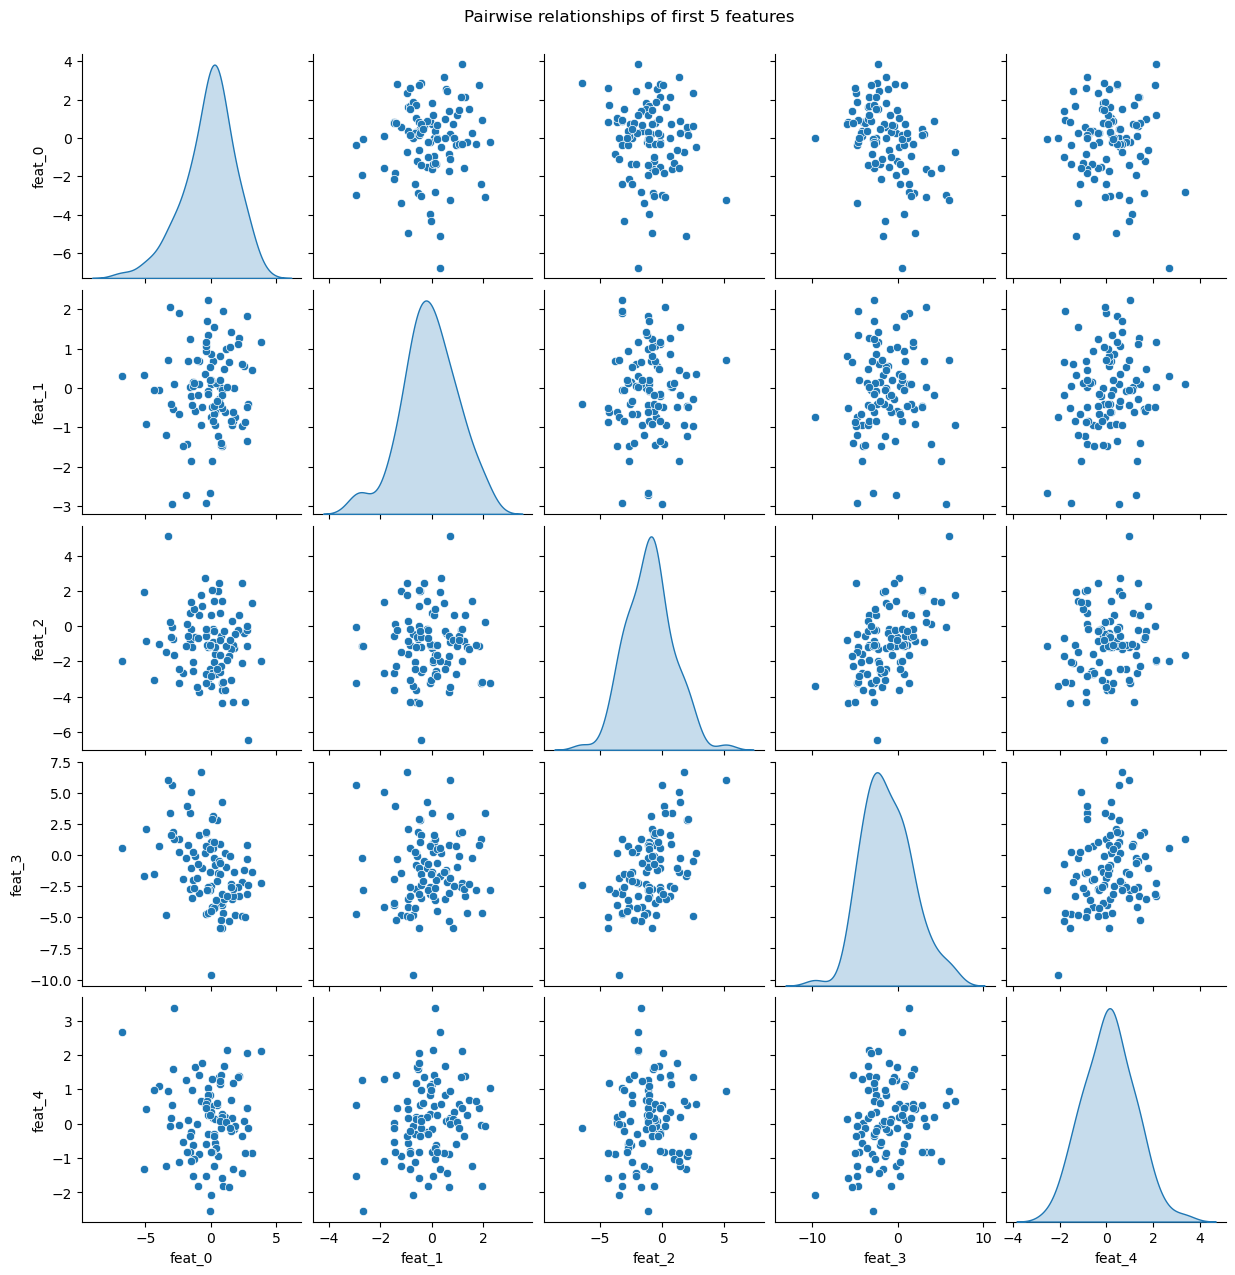

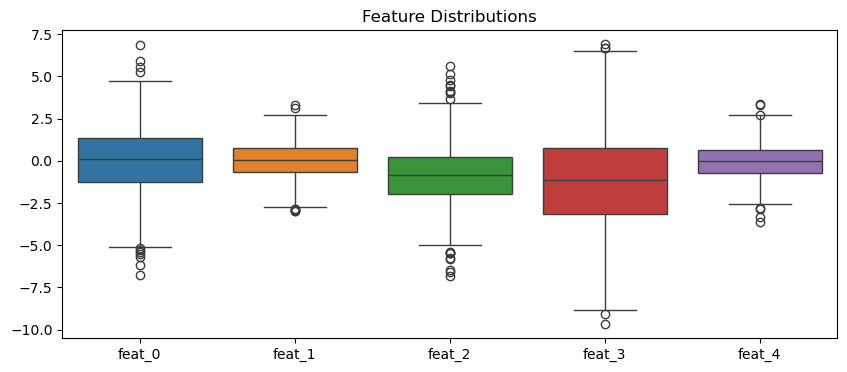

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize subset of features
subset_df = data.iloc[:, :5].copy() 

# Pairplot (excluding target for blindness if this was whole dataset, 
# but here we can inspect structure)
sns.pairplot(subset_df.sample(100), diag_kind='kde')
plt.suptitle('Pairwise relationships of first 5 features', y=1.02)
plt.show()

# Check for outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=subset_df)
plt.title("Feature Distributions")
plt.show()

## Training and hyperparameter tuning

- Generally, you always want to tune. The default parameters aren't necessarily better, it depends on your data.

- **Train multiple machine learning models** of different complexity: two models may perform similarly but use input variables in different ways. If after training a model we only explain one of them, we might have biased conclusions of what variables characterize the outcome [*Low et al. (2024). Identifying bias in models that detect vocal fold paralysis from audio recordings using explainable machine learning and clinician ratings. PLOS Digital Health*]. 
    - At least train a linear model (lasso, ridge, linear SVM) and an ensemble model (XGBoost or LightGBM) to compare linear vs. non-linear performance.

- **Hyperparameter** is something that you define manually or through optimization (regularization term in a linear model). Whereas **parameters** are something estimated during training (e.g., coefficients of a linear model). 

**Performance within the training set:**

| Parameter Set | Strategy | Result (Training Set) |
|---|---|---|
| Parameter set 1: `[C = 0.01, penalty='L1']` | do k-fold CV | avg. F1 = 0.8 |
| Parameter set 2: `[C = 0.1, penalty='L1']` | do k-fold CV | avg. F1 = 0.78 |
| Parameter set 3: `[C = 1, penalty='L1']` | do k-fold CV | avg. F1 = 0.81 |
| ... | ... | ... |
| Parameter set 8: `[C = 10, penalty='L2']` | do k-fold CV | avg. F1 = 0.71 |

Then you use the parameter set that had the highest performance on the **test set**.    
`estimator.best_params_` -> `Parameter set 3: [C = 1, penalty='L1']` 

- **Tip**: use lower numbers here for k-fold: k=5, but if it's very slow, k=3

- **To choose which hyperparameters to optimize**, google/ask ChatGPT. To choose the possible values, start with the default and then add one or two in each direction. Don't use consecutive values (they probably produce the same result). So you need to understand a bit about the hyperparameter to know what makes sense. The default C parameter for SVM is C=1. So what would make sense is `C=[0.01, 0.1, 1, 10]`. However, for another argument values like `[1, 5, 10]` might make sense. You'll need to read up on discussions online. If the best value was the highest or lowest, add 1-3 more values in that direction and re-run if you want.

- If your final results is k-fold then you **have to** use nested k-fold for hyperparameter tuning.

- Use a proper **scoring argument** for hyperparameter tuning depending on if it is a classification or regression task and what exactly you're trying to optimize: https://scikit-learn.org/stable/modules/model_evaluation.html
    - Generally F1 should be better than accuracy in case there is imbalanced data. 

- You can use the same `random_state` for cross-validation or bootstrapping across different estimators so they all use the same test-sets.

- **More advanced**: Consider using `RandomSearchCV` for faster computation which means maybe you add more possible values than you would with `GridSearchCV`. Maybe Bayesian optimization instead of Gridsearch and Randomized search. People use `Optuna` in deep learning, it's a lot faster. `tune-sklearn` is a sklearn style wrapper for that: https://github.com/ray-project/tune-sklearn or you can use `BayesianSearchCV`: https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html

In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define model and parameters
svc = SVC(probability=True, random_state=42)
param_grid = {
    'classifier__C': [0.1, 1, 10], 
    'classifier__kernel': ['linear']
}

# Add model to pipeline
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', svc)])

# Grid Search
# Note: 'classifier__C' notation accesses the param inside pipeline
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV F1 score: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_

Best params: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Best CV F1 score: 0.153


## Evaluation

- **Report** should include all the models and multiple metrics.

- **Classification**: confusion matrix and
    - **Simple metrics**: sensitivity, specificity, precision
    - **Summary metrics**: accuracy, F1-score
    - **Multi-threshold metrics**: ROC AUC (misleading in imbalanced test sets), Area under the Precision Recall curve (better for imbalanced test sets)
    - Full function to output table and figures with additional metrics: https://github.com/danielmlow/construct-tracker/blob/main/src/construct_tracker/machine_learning/metrics_report.py 

- **Regression**:  RMSE, MAE, R² 

- **Error analysis**: have a look at a random selection of false positives and false negatives (or predictions with large errors in a regression task) to understand what the model is getting wrong to potentially fix it.

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       180
           1       0.69      0.45      0.55        20

    accuracy                           0.93       200
   macro avg       0.82      0.71      0.75       200
weighted avg       0.92      0.93      0.92       200

ROC AUC: 0.928
Average Precision (AUPRC): 0.655


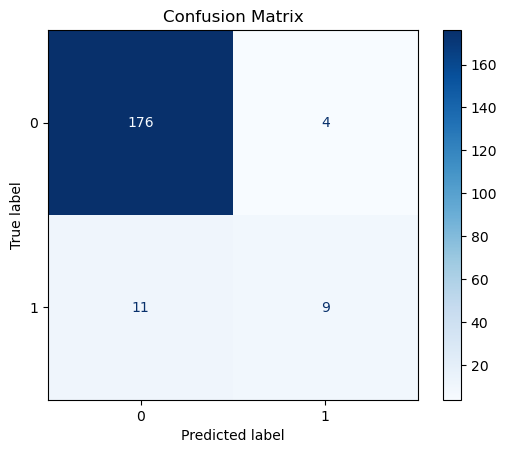

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")
print(f"Average Precision (AUPRC): {average_precision_score(y_test, y_prob):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Feature importance
- In some **linear models** (logistic regression or linear regression), the absolute values of the standardized regression coefficients are a measure of how important the feature is for prediction.
- **Other models** → interpretable and explainable machine learning.
- **Assess collinearity** (high correlation between features, which will bias feature importance rank; lab 6).
    - Use **LOFO** (you need to set the threshold of Spearman rho to 0.8, by default it is 1: https://github.com/aerdem4/lofo-importance).
    - Or remove the "y" dependent variable, and you can do a pairwise Spearman correlation between the features, put that into a **clustermap** (`sns.clustermap(df.corr(method='spearman'))`), and keep only the most interpretable/interesting feature out of the features that correlate rho>0.8.
- **SHAP** global summaries.
- **Permutation importance**.

- **Evaluate potential bias**: do important features match hypotheses? Do they dissociate groups in the expected direction? Do certain recording conditions perform better than others and were these done for only one group? Does the model work worse for certain races or age groups? Several metrics can evaluate this (e.g., see packages `AIF360`, `fairlearn`, and `EqualityML`).

- **If bias is detected**: use bias mitigation strategies either during pre-processing (removing variables generating the bias along with variables correlated with these ones), training (adversarial debiasing, prejudice remover), or evaluation (equalized odds, reject option classification). See packages `AIF360`, `fairlearn`, and `EqualityML`.

  0%|          | 0/10 [00:00<?, ?it/s]

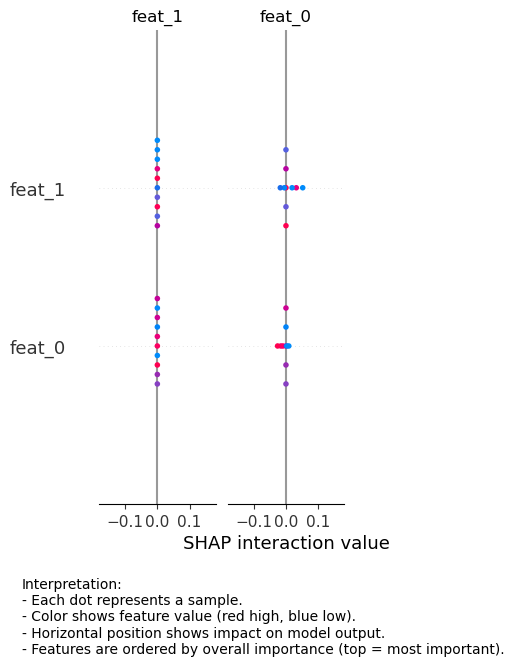

In [ ]:
# TODO: Plot is a bit incorrect.

# import shap

# # Example: SHAP for the best SVM model (using KernelExplainer for generic support)
# # Note: KernelExplainer is slow, we use a small subset background
# # For Tree models, use shap.TreeExplainer

# # Extract the classifier step and preprocessed data
# classifier = best_model.named_steps['classifier']
# X_train_proc_sample = X_train_processed[:50] # Background (already dense)
# X_test_proc_sample = X_test_processed[:10]  # Instances to explain (already dense)

# # Using a linear model approximation for speed in this demo
# # summary_plot is typically used
# try:
#     # Use predict_proba if available (for probability=True in SVC), else decision_function or predict
#     if hasattr(classifier, "predict_proba"):
#         model_predict = classifier.predict_proba
#     else:
#         model_predict = classifier.predict

#     explainer = shap.KernelExplainer(model_predict, X_train_proc_sample)
#     shap_values = explainer.shap_values(X_test_proc_sample)
    
#     # Feature names
#     ohe_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
#     feature_names = numeric_features + ohe_feature_names
    
#     shap.summary_plot(shap_values, X_test_proc_sample, feature_names=feature_names, show=False)
#     # Adjust layout manually
#     plt.gcf().subplots_adjust(bottom=0.25, right=0.85)  # adjust as needed

#     # Add interpretation guidance
#     plt.figtext(0.01, 0.02,
#                 "Interpretation:\n"
#                 "- Each dot represents a sample.\n"
#                 "- Color shows feature value (red high, blue low).\n"
#                 "- Horizontal position shows impact on model output.\n"
#                 "- Features are ordered by overall importance (top = most important).",
#                 fontsize=10, ha="left", va="bottom")

#     plt.show()
    
# except Exception as e:
#     print(f"SHAP explanation skipped (shap might not be installed or other error): {e}")

In [29]:
preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['category_A', 'category_B', 'category_C'], dtype=object)

In [27]:
preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['category_A', 'category_B', 'category_C'], dtype=object)

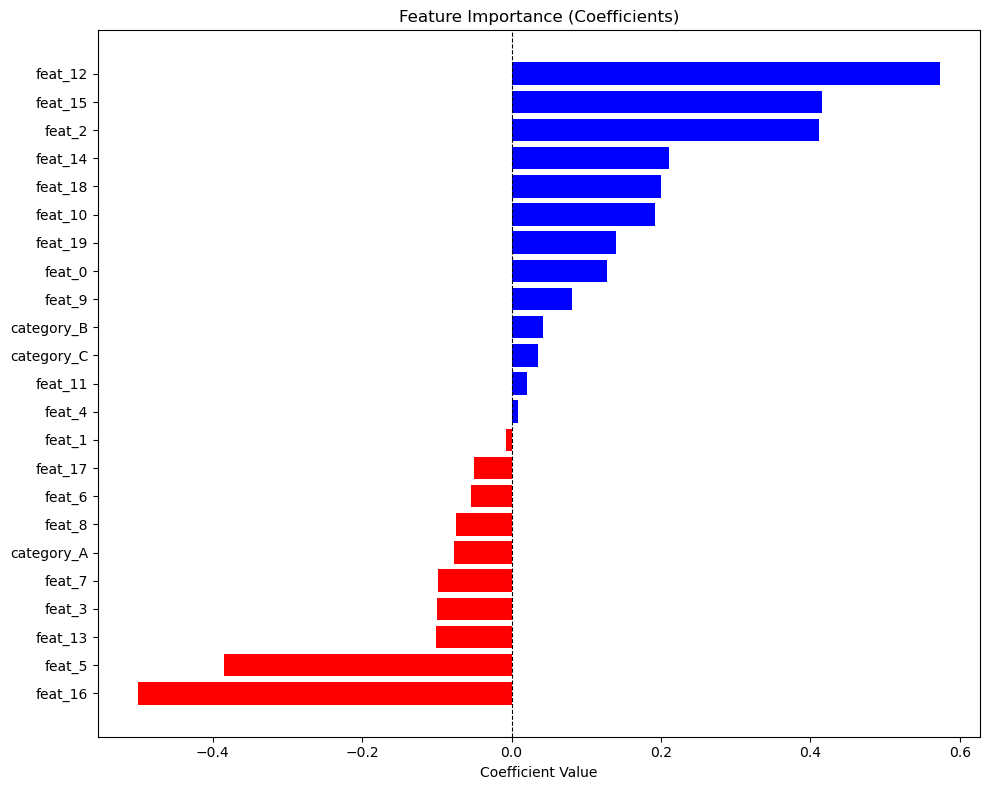

In [34]:
# Feature Importance using Coefficients (Linear Model)
# If the chosen model is linear (e.g., Linear SVM or Logistic Regression), we can plot coefficients.

try:
    classifier = best_model.named_steps['classifier']
    
    # Check if linear kernel was selected or if it's another linear model
    if hasattr(classifier, 'coef_'):
        # For multiclass, coef_ has shape (n_classes, n_features). 
        # For binary, it's (1, n_features).
        coefs = classifier.coef_.flatten() # Assuming binary classification for simplicity or taking first class
        
        # Get feature names
        ohe_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
        feature_names = np.array(numeric_features + ohe_feature_names)
        
        # Sort by magnitude or value
        # Let's sort by value
        indices = np.argsort(coefs)
        sorted_coefs = coefs[indices]
        sorted_names = feature_names[indices]
        
        plt.figure(figsize=(10, 8))
        colors = ['red' if c < 0 else 'blue' for c in sorted_coefs]
        plt.barh(range(len(sorted_coefs)), sorted_coefs, color=colors)
        plt.yticks(range(len(sorted_coefs)), sorted_names)
        plt.xlabel('Coefficient Value')
        plt.title('Feature Importance (Coefficients)')
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # Line at x=0
        plt.tight_layout()
        plt.show()
    else:
        print("The best model selected is non-linear (e.g. RBF kernel) or tree-based and does not have simple coefficients. Using SHAP plot above is recommended.")

except Exception as e:
    print(f"Could not plot coefficients: {e}")

In [33]:
len(coefs)

23

In [30]:
ohe_feature_names

['category_A', 'category_B', 'category_C']

## Code

- **Modularize** your code by turning small sections into functions. You can put functions into other local scripts and import the script.

- **Add tests** to your code:
    - Good to add as many of those tests as you can (e.g., a function or operation should return a certain value given a certain input).
    ```python
    assert df_after_merging.shape == (1425, 23) # common mistake is to assume the merge did what you thought it did
    for dtype in df.dtypes:
        assert dtype != 'object'
    ```

## More on reproducibility

- **When you're done** with the project, in the terminal / console, you can run (a) `conda env export > requirements.yml` (without quotation marks) or `pip freeze >> requirements.txt` to save the versions of all installed packages so others can install.
- **Save all code** in a GitHub repository or Open Science Framework and add a link in publication.
- **Even better than virtual environments**: docker containers or singularity containers (they better guarantee the reproducibility of the code).

- **Consider saving the model** for perfect reproducibility:
    ```python
    import pickle
    with open('model_name.pkl', 'wb') as file:
        pickle.dump(trained_model, file)
    with open('model_name.pkl', 'rb') as file:
        trained_model = pickle.load(file)
    ```

    ```python
    import joblib

    # Saving the entire pipeline
    model_filename = 'final_model_pipeline.pkl'
    joblib.dump(best_model, model_filename)

    print(f"Model saved to {model_filename}")

    # Defensive coding example
    def merge_and_validate(df1, df2, on_col, expected_shape):
        merged = pd.merge(df1, df2, on=on_col)
        assert merged.shape == expected_shape, f"Shape mismatch: {merged.shape} != {expected_shape}"
        return merged

    ```

## Resources

- **Kapoor, S., et al.** (2023). Reforms: Reporting standards for machine learning based science. *arXiv preprint arXiv:2308.07832*. https://arxiv.org/pdf/2308.07832.pdf
- **Raschka, S.** (2018). Model evaluation, model selection, and algorithm selection in machine learning. *arXiv preprint arXiv:1811.12808*.

---
Based on: *Low, D. M. (2023). Checklist for Machine Learning Analyses. v0.1*